# Exploratory Data Analysis: Grantnav Dataset (Downloaded 20/04/2021)

**Research Question**
    
Is it possible to predict grant value from description keywords, location-based data and/or other characteristics?

## 0.0 Libraries

In [2]:
%load_ext autoreload
%autoreload 2

#system
import os
import sys
from os.path import join as pj
module_path = os.path.abspath(pj('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# data
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from dateutil.relativedelta import relativedelta
import datetime

# viz
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import missingno as msno

# configurations
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import configparser

#stats
import scipy
import statsmodels.api as sm

# utils
from src.d00_utils import print_helper_functions as phf

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.1 Configurations and Directories

In [3]:
# not used in this stub but often useful for finding various files
project_dir = Path().resolve().parents[1]
print(project_dir)

# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
_ = load_dotenv(find_dotenv())

raw_dir = pj(project_dir, 'data', os.environ.get('RAW_DIR'))
interim_dir = pj(project_dir, 'data', os.environ.get('INTERIM_DIR'))
processed_dir = pj(project_dir, 'data', os.environ.get('PROCESSED_DIR'))

/Users/marclawson/repositories/grantnav_10k_predictor


## 1.0 Load Data

In [4]:
data = pd.read_csv(pj(interim_dir,'grantnav_data.csv'), index_col=0)

## 1.1 Size and shape

In [5]:
data.head()
data.shape

,identifier,currency,title,description,amount_awarded,award_date,recipient_org_identifier,recipient_org_name,funding_org_identifier,funding_org_name,planned_dates_duration_months
0,360G-SE-2011020480EXCH_2012-04-16,GBP,Active Men Project,Funding under Sport England's Sportsmatch fund...,41100.0,2012-04-16,GB-COH-07626625,Positive Futures North Liverpool Ltd,GB-COH-RC000766,Sport England,11.0
1,360G-SE-2012000041EXCH_2012-04-16,GBP,Sporting Futures Leadership Academy,Funding under Sport England's Sportsmatch fund...,6000.0,2012-04-16,GB-CHC-1041422,Sporting Futures,GB-COH-RC000766,Sport England,11.0
2,360G-SE-2012000173EXCH_2012-04-16,GBP,Choices,Funding under Sport England's Sportsmatch fund...,36750.0,2012-04-16,GB-COH-01696490,Greenbank Project,GB-COH-RC000766,Sport England,11.0
3,360G-SE-2012000554EXCH_2012-04-16,GBP,Florrie Sports,Funding under Sport England's Sportsmatch fund...,15000.0,2012-04-16,GB-COH-05330850,The Florence Institute Trust Ltd,GB-COH-RC000766,Sport England,11.0
4,360G-SE-2010011194LOTT_2012-04-17,GBP,Engaging children and adults in Kwic Cricket s...,Funding under Sport England's Small Grants fun...,692.0,2012-04-17,360G-SE-Barmston Village Primary School,Barmston Village Primary School,GB-COH-RC000766,Sport England,3.0


(525023, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525023 entries, 0 to 561423
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   identifier                     525023 non-null  object 
 1   currency                       525023 non-null  object 
 2   title                          525023 non-null  object 
 3   description                    525023 non-null  object 
 4   amount_awarded                 525023 non-null  float64
 5   award_date                     525023 non-null  object 
 6   recipient_org_identifier       525023 non-null  object 
 7   recipient_org_name             525020 non-null  object 
 8   funding_org_identifier         525023 non-null  object 
 9   funding_org_name               525023 non-null  object 
 10  planned_dates_duration_months  525023 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


## 1.2 Grant Value Statistics (Handling Outliers)

In [7]:
grant_value = data['amount_awarded']
phf.print_full(grant_value.describe())

count             525,023.00
mean               39,985.73
std                78,117.54
min                   300.00
25%                 4,000.00
50%                 9,700.00
75%                30,000.00
max             1,381,438.97
Name: amount_awarded, dtype: float64

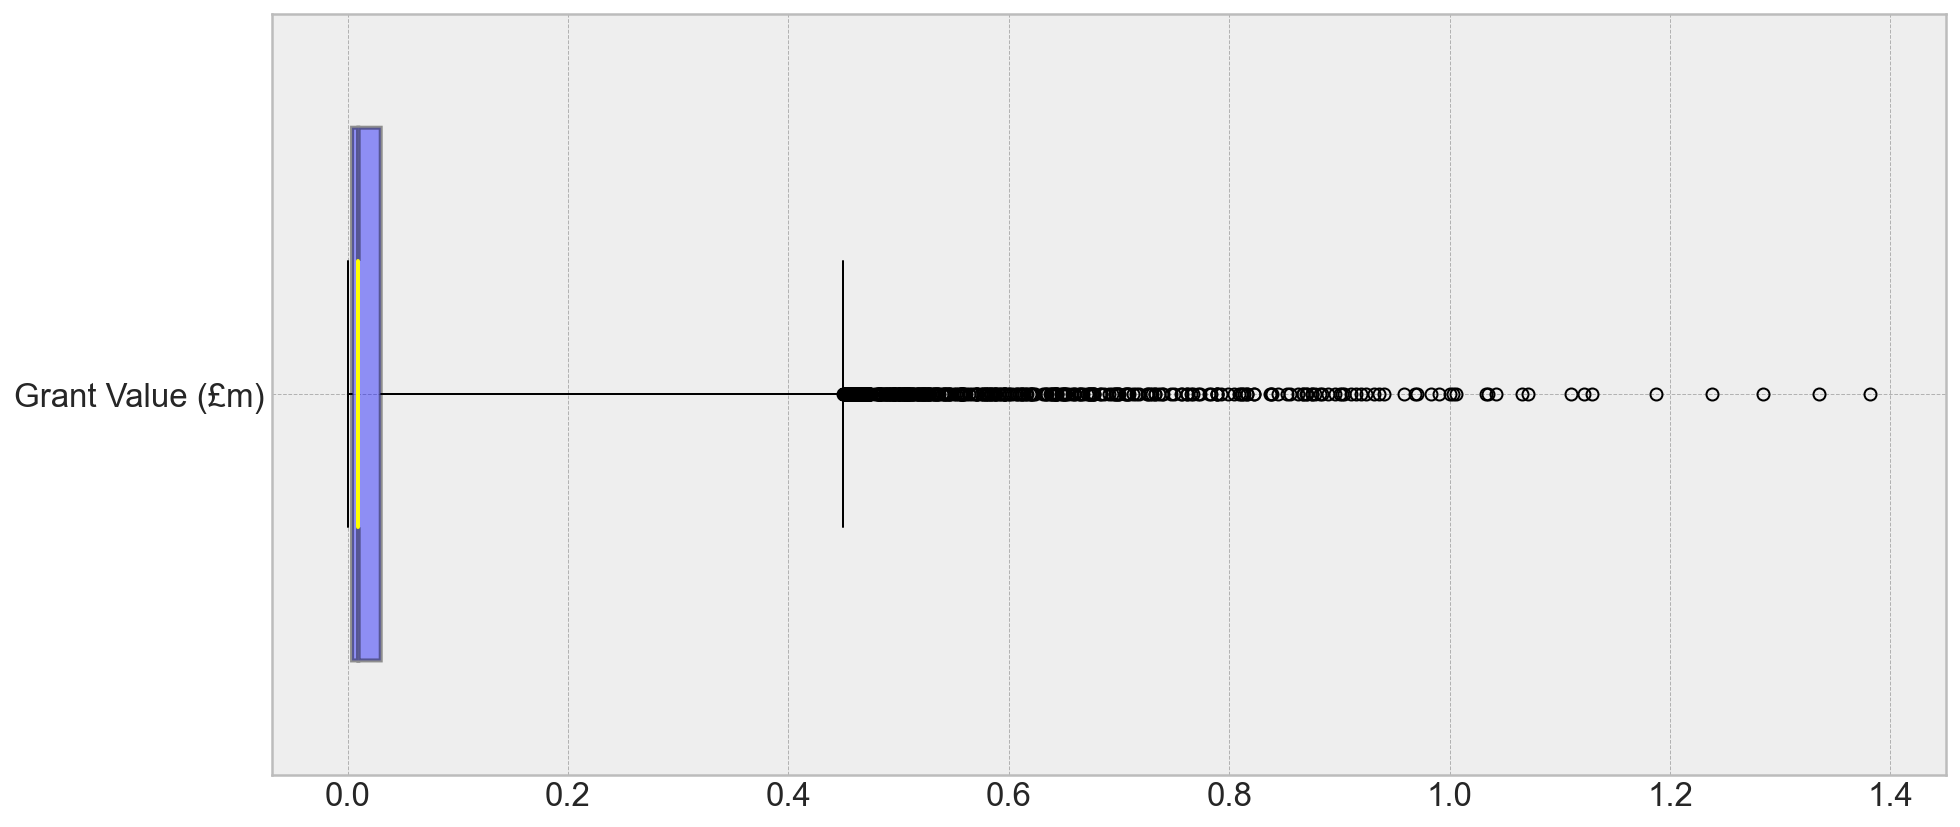

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
kwargs = {
    'vert': False,
    'whis': [0.3,99.7],
    'notch': True,
    'labels': [f'Grant Value (\u00A3m)'],
    'widths': .7,
    'patch_artist': True,
    'medianprops': dict(linestyle='-', linewidth=2, color='Yellow'),
    'boxprops': dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
}
ax.boxplot(grant_value/1000000, **kwargs)
plt.show();

## 1.3 Time Series (Award Date)

The remaining variables to investigate are the award dates and description word vectors.  I will investigate the time series first.

In [9]:
awards_by_date = data.groupby('award_date')['amount_awarded'].mean().reset_index()
awards_by_date['award_date'] = pd.to_datetime(awards_by_date['award_date'])
awards_by_date = awards_by_date.set_index('award_date',drop=True)

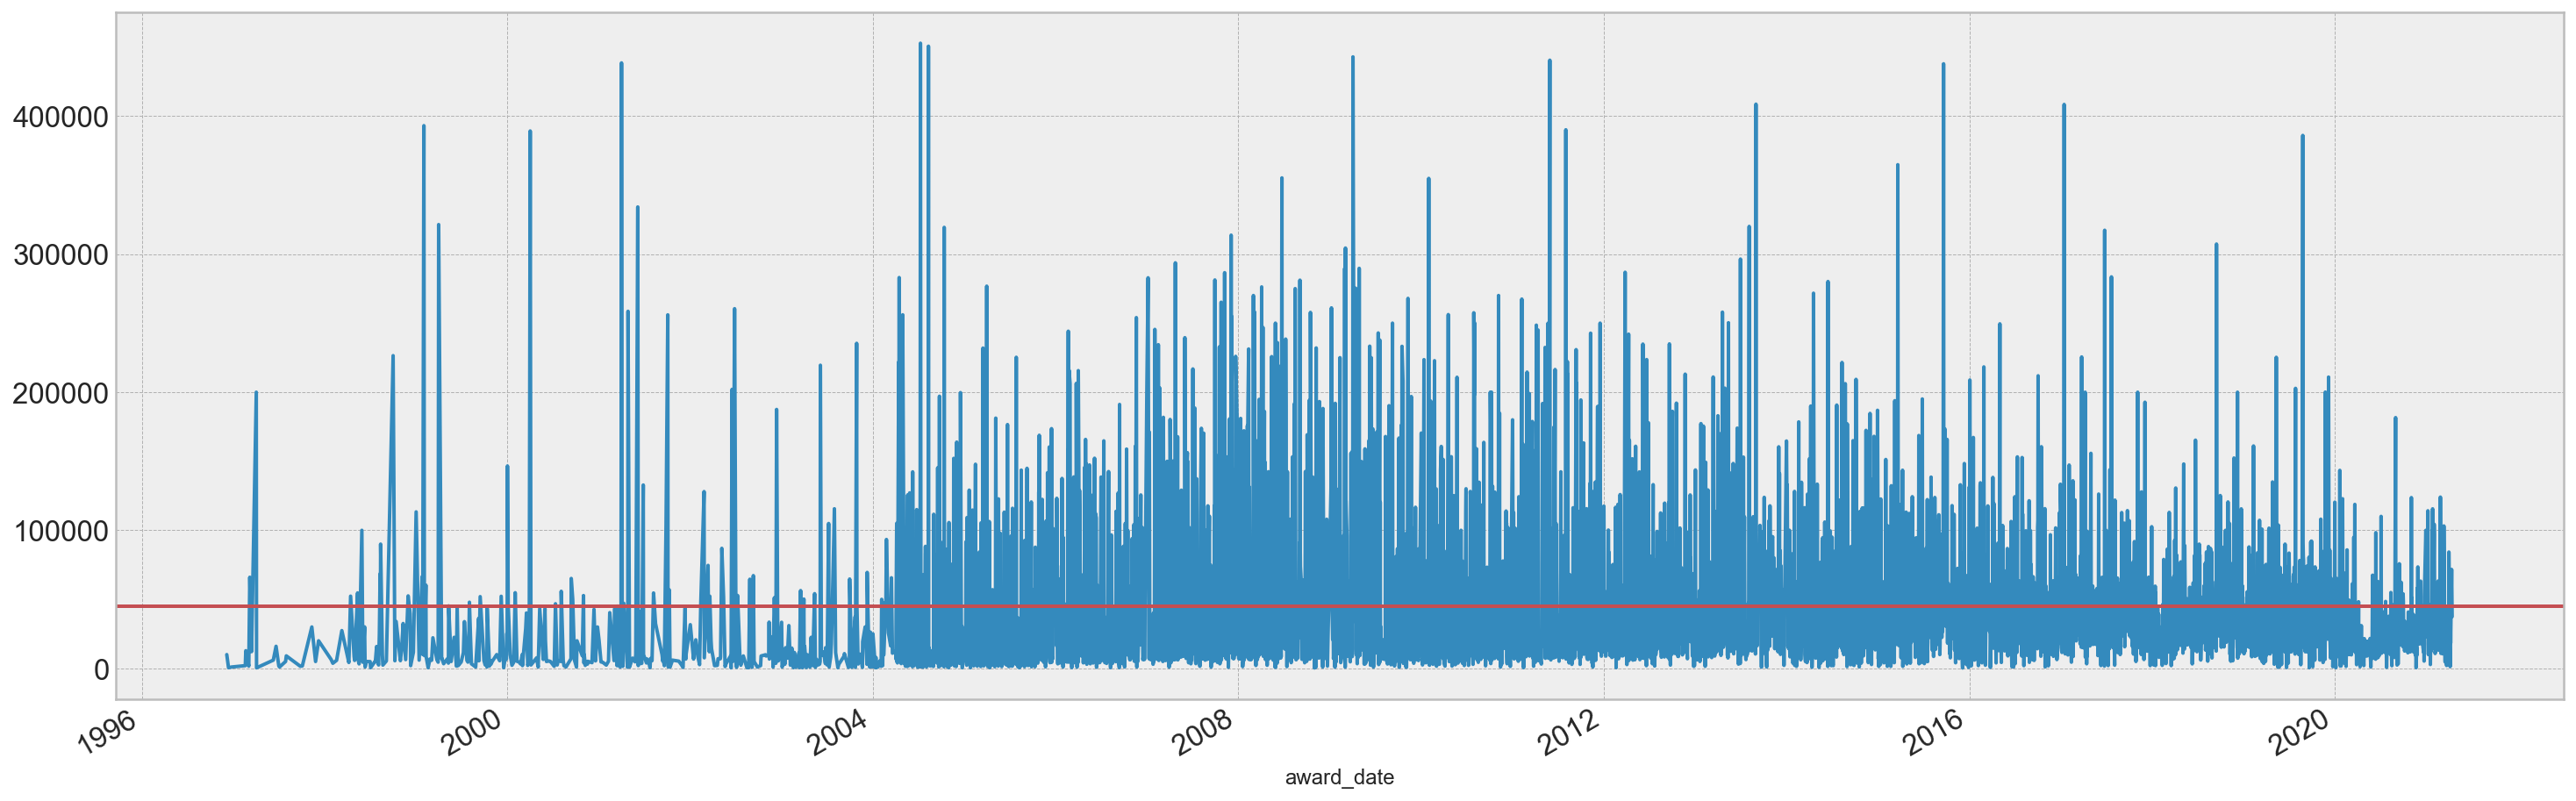

In [10]:
awards_by_date['amount_awarded'].plot(figsize=(25,8))
plt.axhline(awards_by_date['amount_awarded'].mean(), color='r')
plt.show();

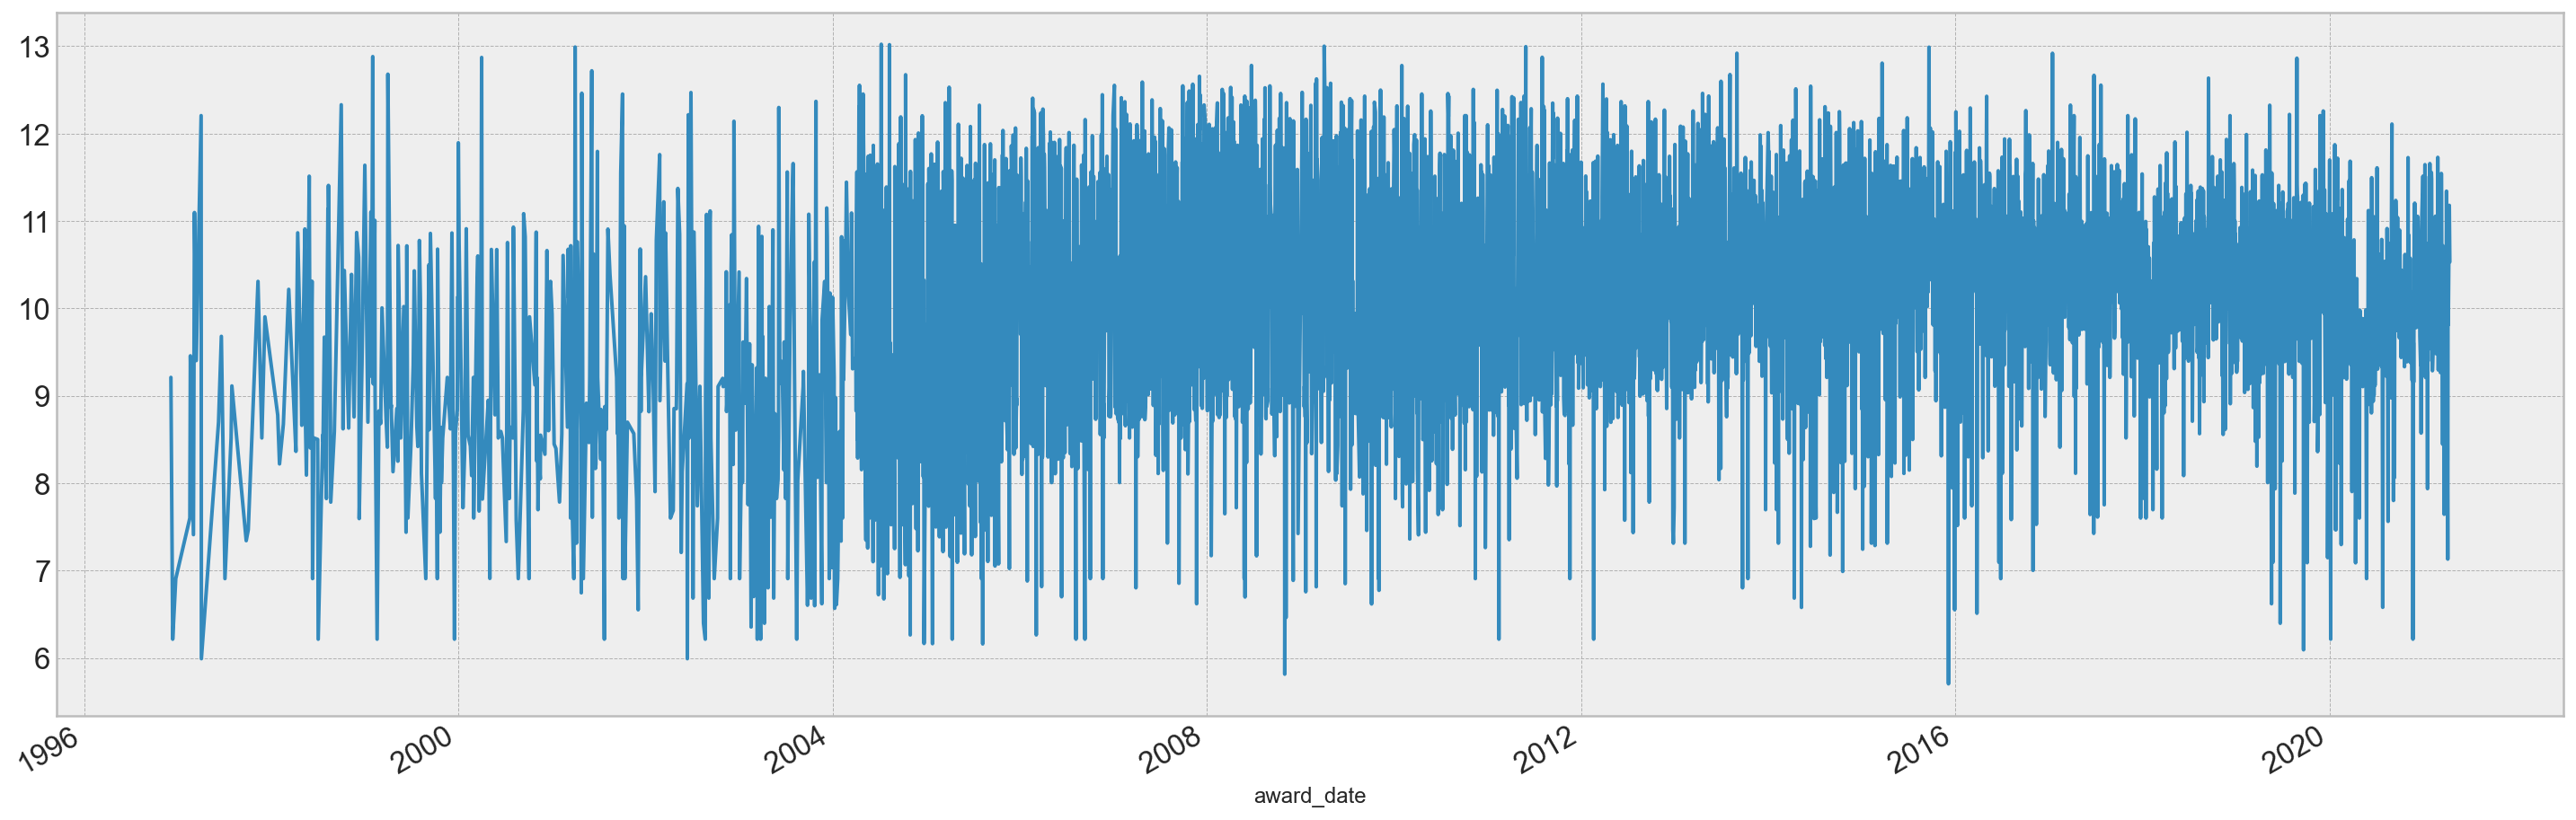

In [11]:
np.log(awards_by_date['amount_awarded']).plot(figsize=(25,8));

Check when the 'The National Lottery Community Fund' started to record data as there seems to be quite a volumn around 2004.

In [12]:
nat_lott = 'The National Lottery Community Fund'
nat_lott_record_start = data[data['funding_org_name']==nat_lott]['award_date'].min()
nat_lott_record_start

'2004-04-01'

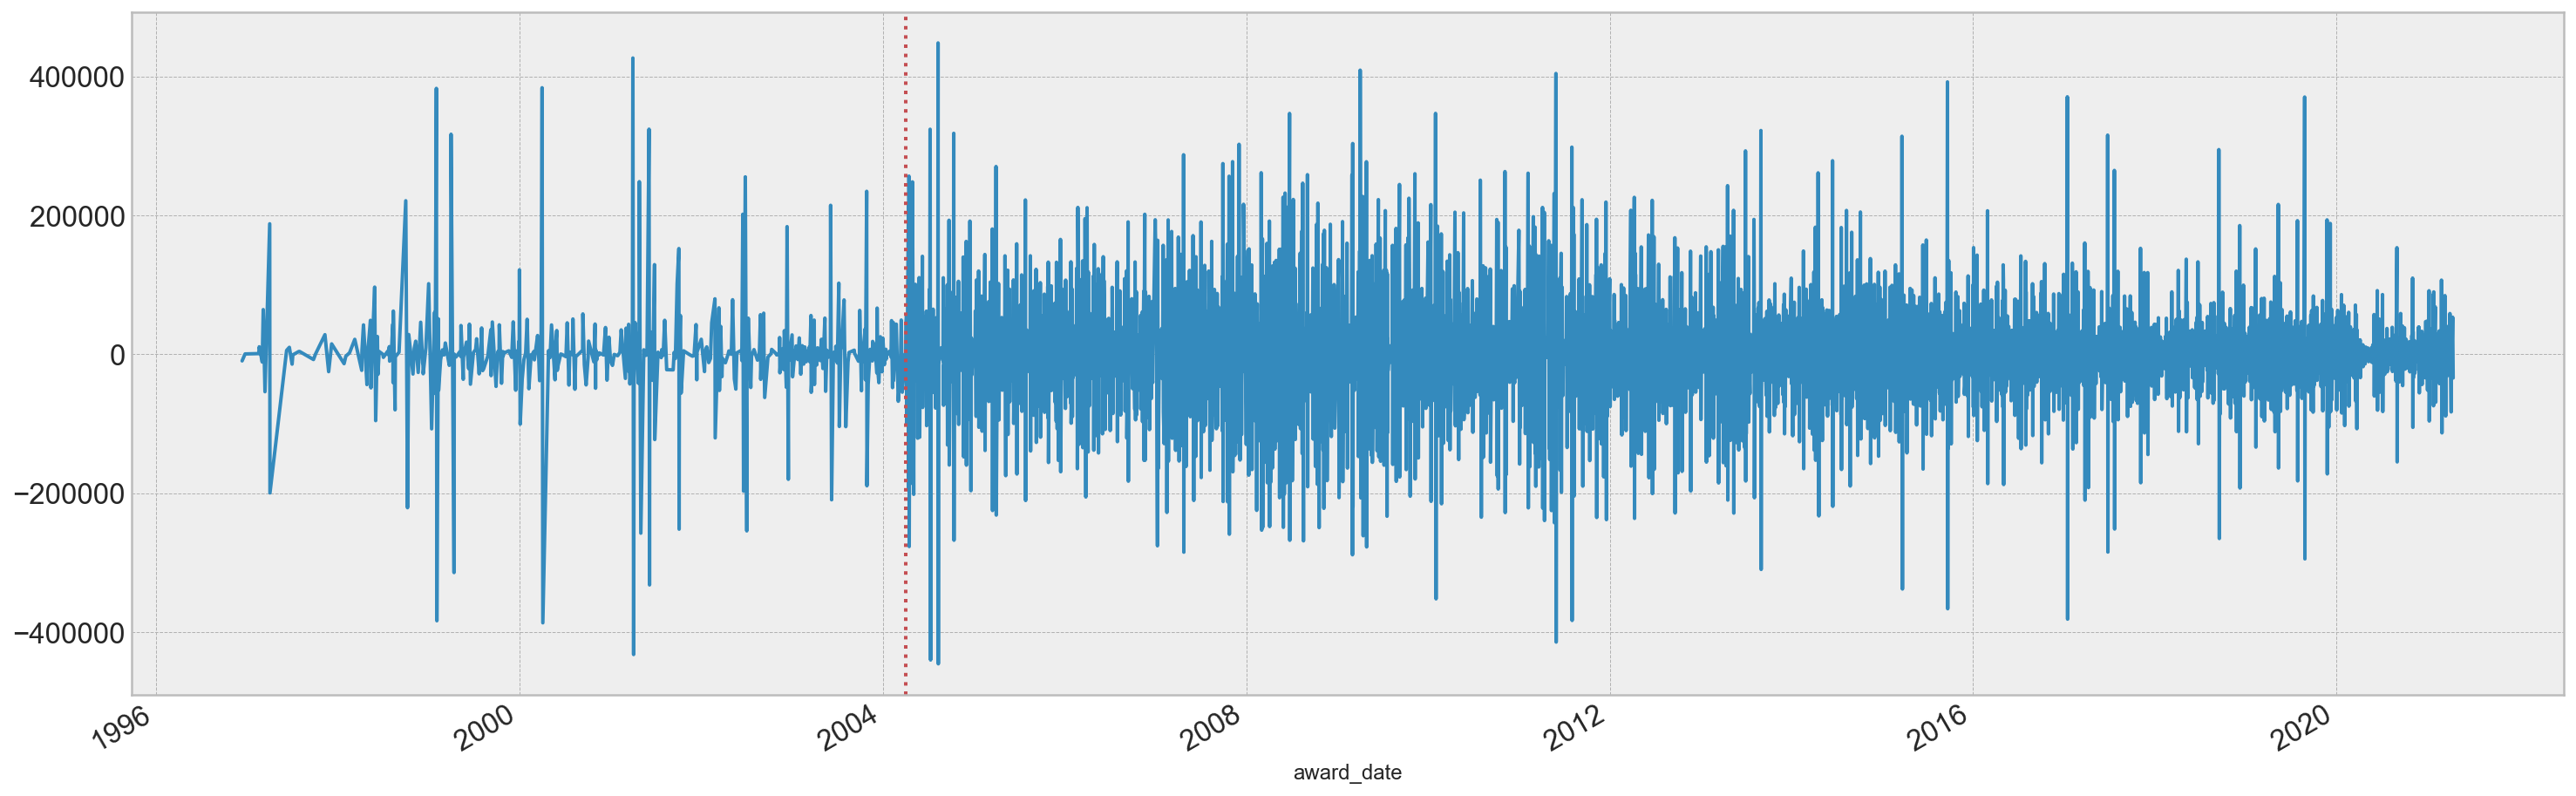

In [13]:
awards_by_date['amount_awarded'].diff().plot(figsize=(25,8))
plt.axvline(nat_lott_record_start, color='r',linestyle=':',linewidth=2)
plt.show();

#### Resample to weekly and monthly means

In [14]:
awards_by_date['amount_awarded'].head()

award_date
1996-12-05    10000.00
1996-12-12      500.00
1996-12-24     1000.00
1997-02-17     2000.00
1997-02-19    12801.81
Name: amount_awarded, dtype: float64

In [15]:
awards_by_date_pre2004 = awards_by_date[awards_by_date.index>=nat_lott_record_start]
awards_by_date_pre2004

,amount_awarded
award_date,
2004-04-01,12541.579710
2004-04-02,6815.920635
2004-04-03,50000.000000
2004-04-05,105029.111111
2004-04-06,4928.823529
...,...
2021-04-06,1250.000000
2021-04-07,38497.186441
2021-04-08,18246.000000


In [16]:
awards_by_month = pd.DataFrame(awards_by_date_pre2004['amount_awarded'].resample('M').mean(),columns=['amount_awarded'])
awards_by_month

,amount_awarded
award_date,
2004-04-30,75323.743469
2004-05-31,39106.325004
2004-06-30,27412.905141
2004-07-31,54719.422193
2004-08-31,31792.096439
...,...
2020-12-31,34866.189272
2021-01-31,36834.152151
2021-02-28,39693.666232


What happens when we reduce to grants 10k or under?

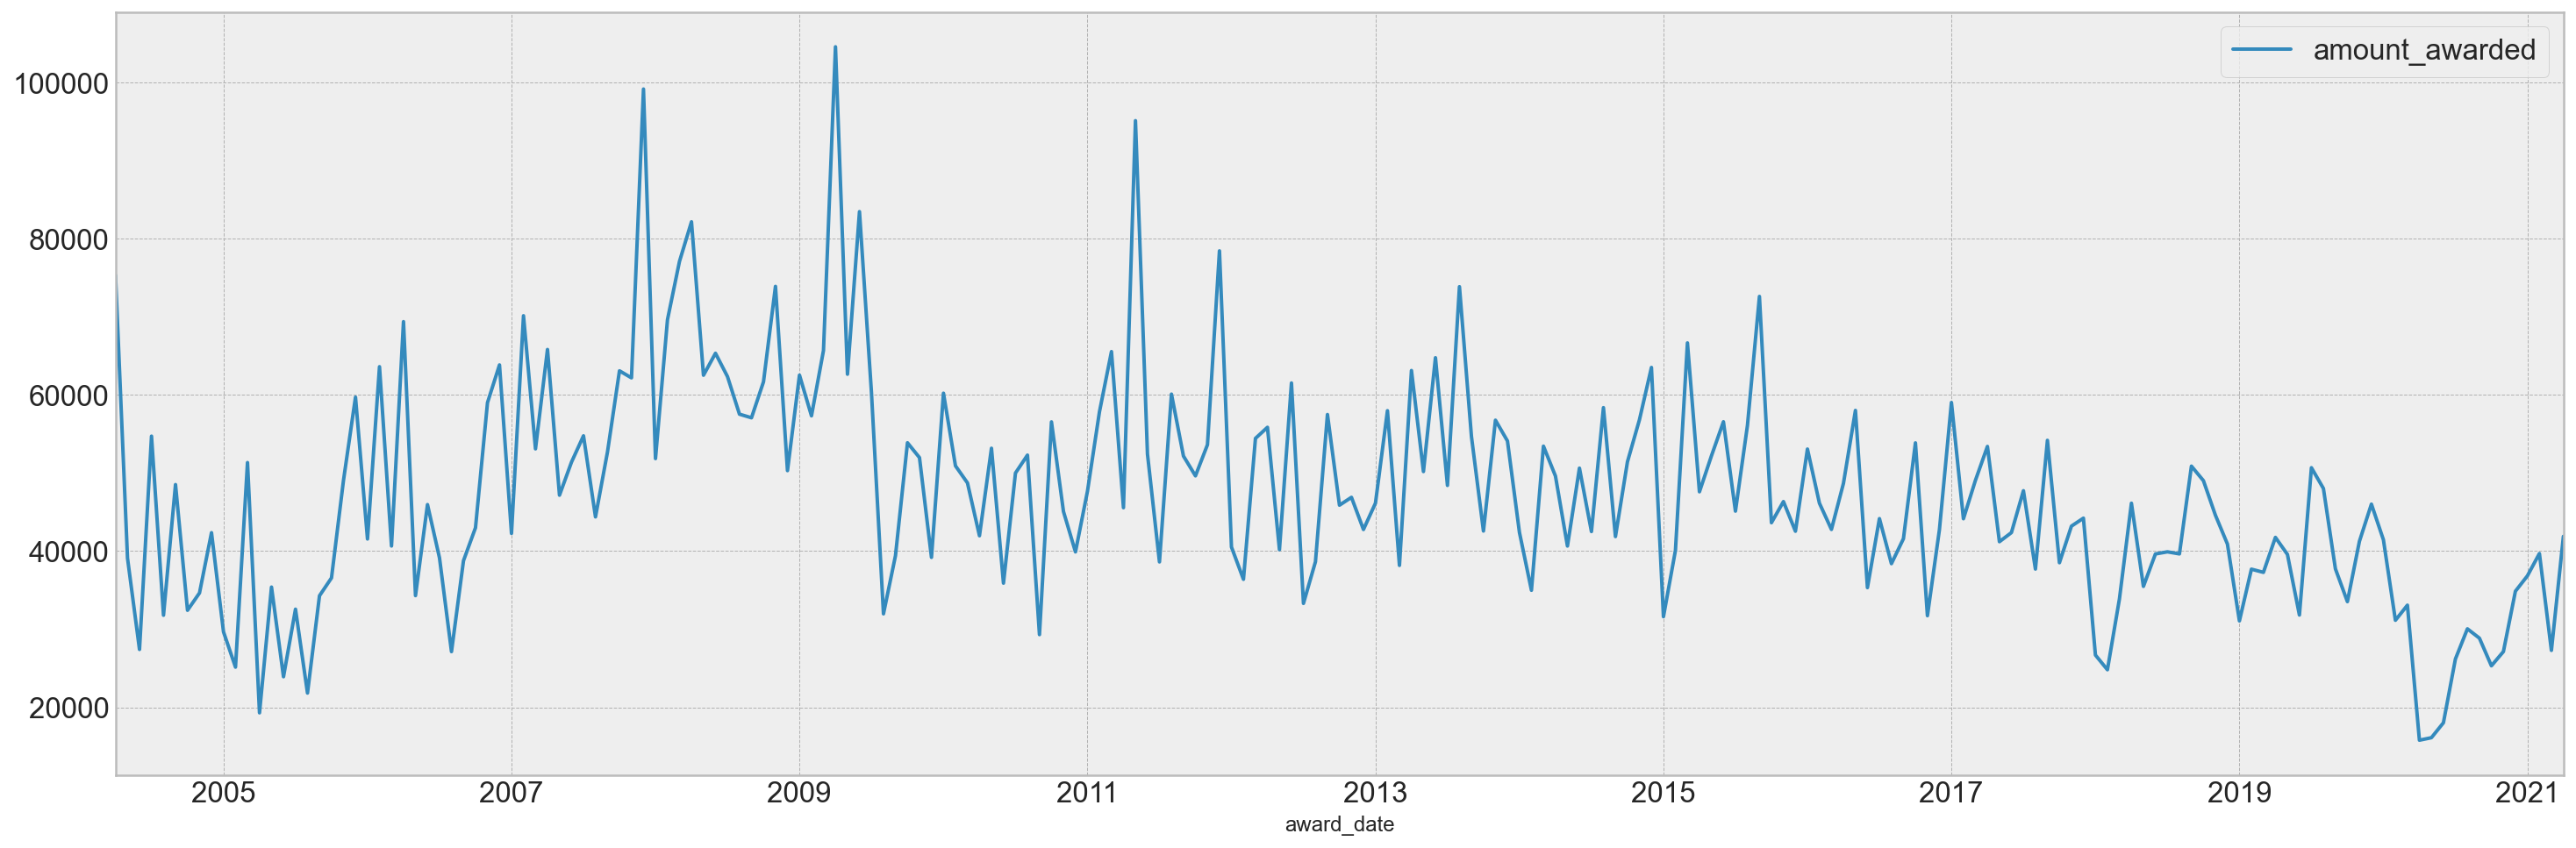

In [17]:
awards_by_month.plot(figsize=(25,8));

<AxesSubplot:xlabel='award_date'>

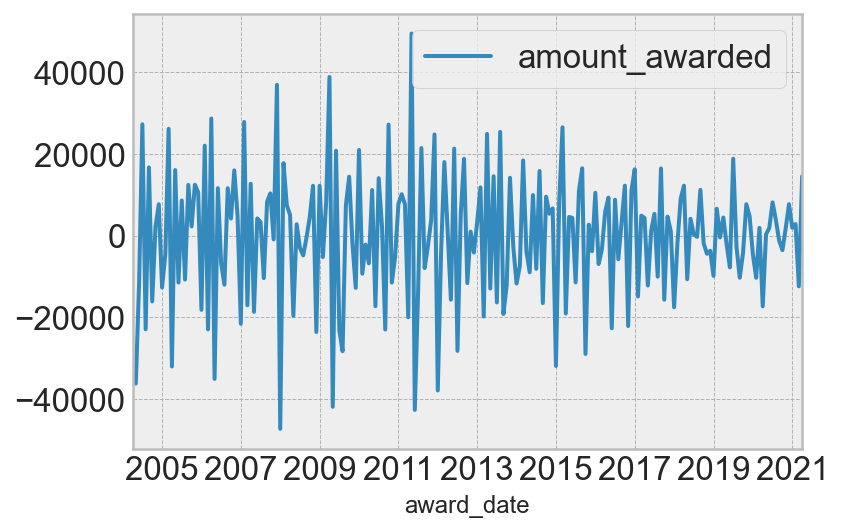

In [18]:
awards_by_month.diff().plot()

### 1.3.1 Ordinary Regression

In [19]:
awards_by_month['lag1'] = awards_by_month['amount_awarded'].shift(1)
shifted_1 = awards_by_month['lag1']

In [20]:
from sklearn.metrics import mean_squared_error
print(f"{mean_squared_error(awards_by_month['amount_awarded'].iloc[1:], shifted_1[1:]):,.0f}")

246,128,743


In [21]:
awards_by_month['amount_awarded'].iloc[1:]
shifted_1[1:]

award_date
2004-05-31    39106.325004
2004-06-30    27412.905141
2004-07-31    54719.422193
2004-08-31    31792.096439
2004-09-30    48518.841556
                  ...     
2020-12-31    34866.189272
2021-01-31    36834.152151
2021-02-28    39693.666232
2021-03-31    27292.653059
2021-04-30    41893.365484
Freq: M, Name: amount_awarded, Length: 204, dtype: float64

award_date
2004-05-31    75323.743469
2004-06-30    39106.325004
2004-07-31    27412.905141
2004-08-31    54719.422193
2004-09-30    31792.096439
                  ...     
2020-12-31    27137.775893
2021-01-31    34866.189272
2021-02-28    36834.152151
2021-03-31    39693.666232
2021-04-30    27292.653059
Freq: M, Name: lag1, Length: 204, dtype: float64

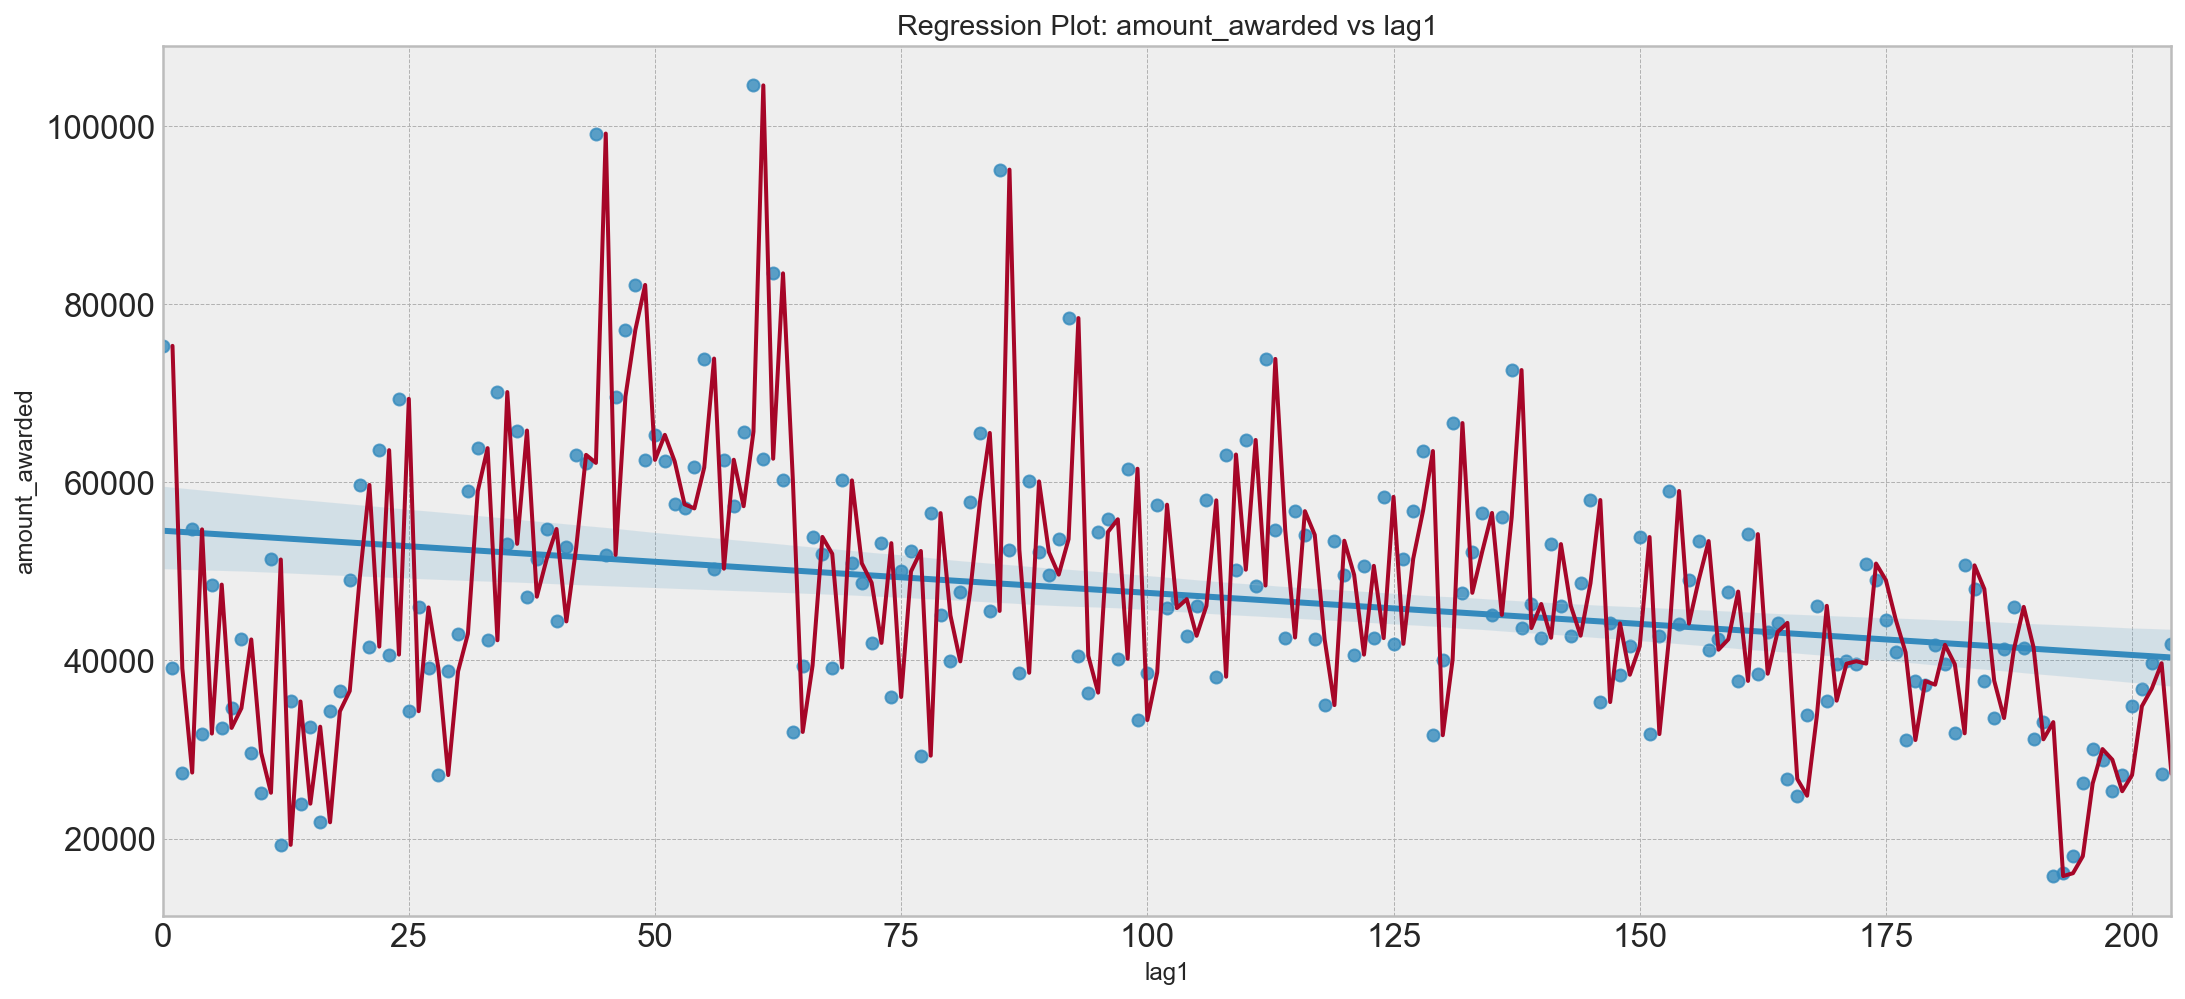

In [22]:
X = awards_by_month.reset_index().index
y = awards_by_month.amount_awarded

pred_values = awards_by_month['lag1']
fig, ax = plt.subplots(figsize=(18,8))
sns.regplot(x=X, y=y, data=awards_by_month, ax=ax)
ax.plot(X, pred_values)
ax.set_title('Regression Plot: amount_awarded vs lag1')
ax.set_xlabel('lag1')
plt.show();

There seems to be some sort of linear association between `amount_awarded` by month and its lag(1).

In [23]:
[(i, 
  mean_squared_error(awards_by_month['amount_awarded'].iloc[i:],
                     awards_by_month['amount_awarded'].shift(i).iloc[i:]))
  for i in range(1, 30)]

[(1, 246128742.52426788),
 (2, 225191616.82995856),
 (3, 220792147.2077153),
 (4, 265782247.36727434),
 (5, 279237238.3224743),
 (6, 292272519.7423159),
 (7, 272522373.57423496),
 (8, 312446253.3651682),
 (9, 307227670.83057064),
 (10, 291300945.88448805),
 (11, 299016230.2883104),
 (12, 281945817.8999665),
 (13, 278902263.85302484),
 (14, 305869518.06189877),
 (15, 331518256.02967155),
 (16, 287327331.8246836),
 (17, 354117671.83233905),
 (18, 341995645.8271561),
 (19, 340315321.4897885),
 (20, 363031732.7889575),
 (21, 355468214.5278956),
 (22, 347949994.3720781),
 (23, 309136774.5867516),
 (24, 340236543.57525223),
 (25, 314375420.0651553),
 (26, 336157437.9373561),
 (27, 359929923.48443556),
 (28, 361139314.56063086),
 (29, 385526909.4420076)]

In [24]:
# correlation lag1
X = awards_by_month[['amount_awarded','lag1']].copy()
X.dropna(inplace=True)

X.corr()

,amount_awarded,lag1
amount_awarded,1.00000,0.39811
lag1,0.39811,1.00000


Let's check correlations for lag3:

In [25]:
awards_by_month['lag3'] = awards_by_month['amount_awarded'].shift(3)
X = awards_by_month[['amount_awarded','lag3']].copy()
X.dropna(inplace=True)

X.corr()

,amount_awarded,lag3
amount_awarded,1.000000,0.459283
lag3,0.459283,1.000000


Let's do a linear regression model on lag1 and lag3

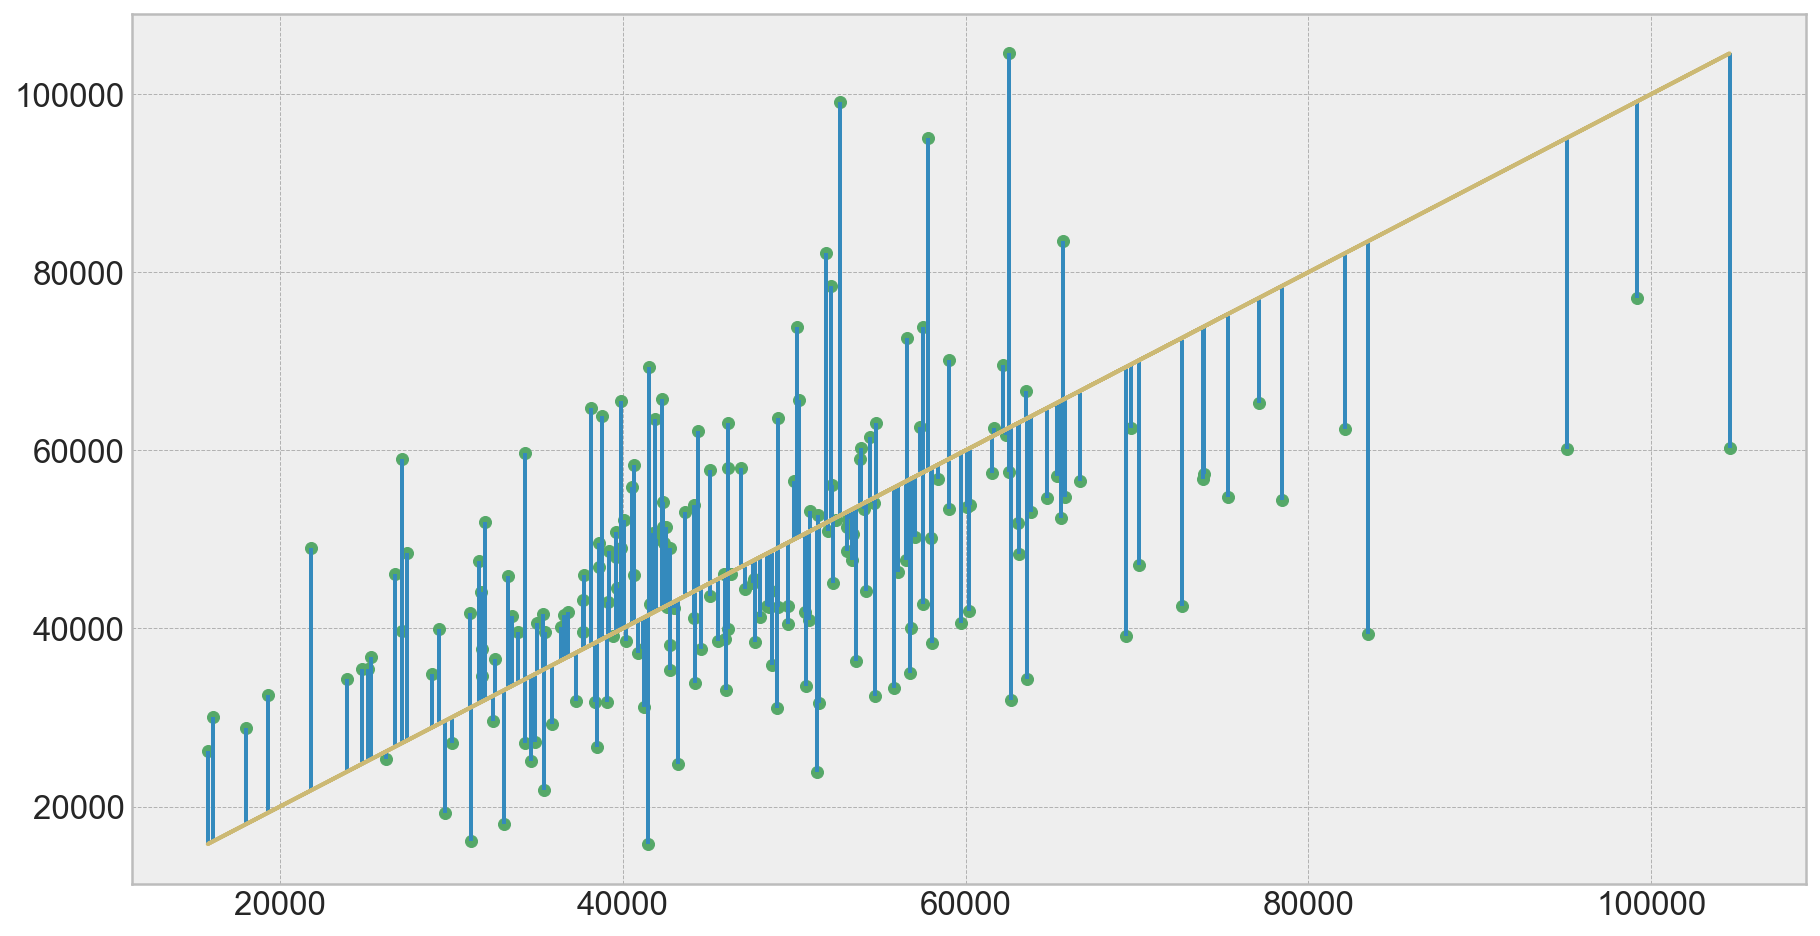

In [26]:
# plot residuals
df = awards_by_month.copy()
fig, ax = plt.subplots(figsize=(15,8))
predictor = 'lag3'
pred_values = df['lag3'].values
df['y_bar'] = df['amount_awarded'].mean()
baseline_residuals = [(i[0]-i[1]) for i in zip(df['amount_awarded'], df['y_bar'])]
new_residuals = [(i[0]-i[1]) for i in zip(df['amount_awarded'], pred_values)]
ax.scatter(df[predictor], df['amount_awarded'], color='g')
ax.plot(df[predictor], pred_values, color='y')
ax.vlines([x for x in df[predictor]], [p for p in pred_values], [y for y in df['amount_awarded']])
plt.show();

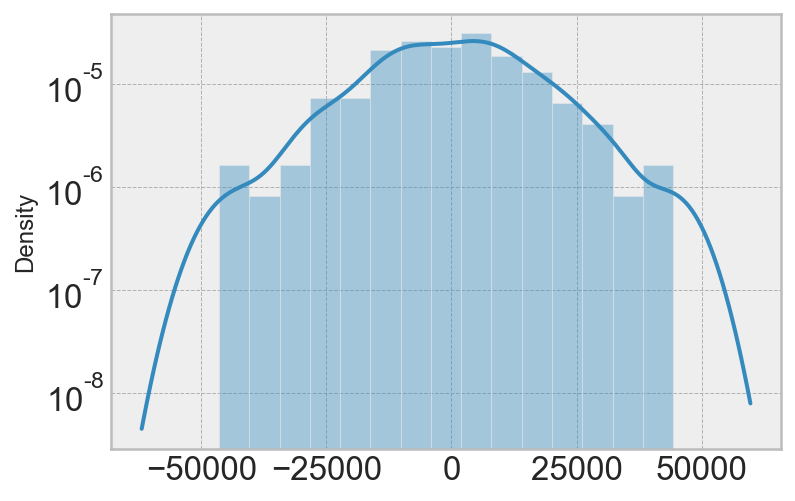

In [27]:
residuals = [i[0]-i[1] for i in zip(pred_values, df['amount_awarded'])]
sns.distplot(residuals)
plt.yscale('log')
plt.show;

In [28]:
df['residuals'] = residuals
df['pred_values'] = pred_values

In [29]:
df.residuals.map(lambda x: x**2).mean()
df.residuals.map(lambda x: x**2).mean()**0.5

220792147.20771533

14859.076256877994

In [30]:
np.allclose(sum(residuals[3:]), 0)

False

It looks like we're out by quite a bit.

If we were to integrate this into the models or the at least the prediction, historical data beyond the last five years may not be very useful.  What happens to the residuals if we look at data since 2016?

#### 5 Years Time Series

,amount_awarded,diff
award_date,,
2016-06-05,14820.000000,12870.000000
2016-06-12,14564.023000,-255.977000
2016-06-19,13301.666667,-1262.356333
2016-06-26,19509.571429,6207.904762
2016-07-03,23482.142857,3972.571429
...,...,...
2021-03-21,15738.100000,2099.300000
2021-03-28,19251.083333,3512.983333
2021-04-04,20467.999203,1216.915869


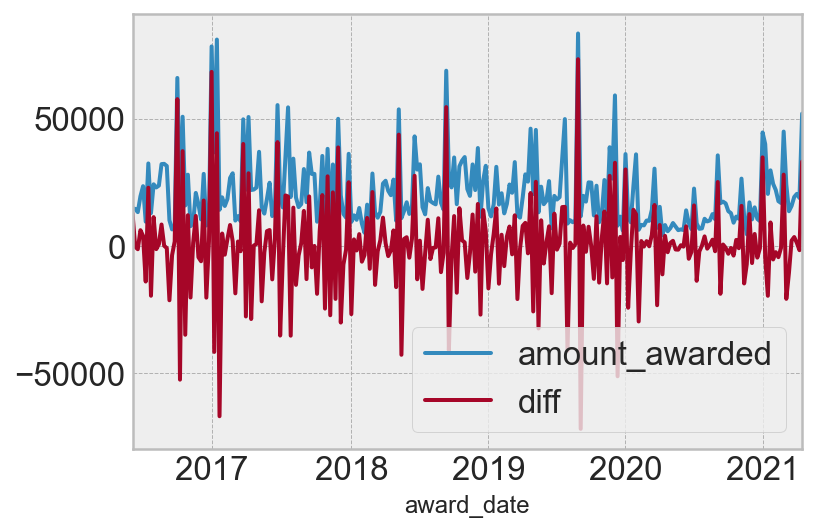

In [31]:
awards_by_week_5y = data.groupby('award_date')['amount_awarded'].median().reset_index()
awards_by_week_5y['award_date'] = pd.to_datetime(awards_by_week_5y['award_date'])
years_ago = datetime.datetime.now() - relativedelta(years=5)
awards_by_week_5y = awards_by_week_5y[awards_by_week_5y['award_date']>=years_ago]
awards_by_week_5y = awards_by_week_5y.set_index('award_date',drop=True)
awards_by_week_5y = pd.DataFrame(awards_by_week_5y.resample('W').mean() ,columns=['amount_awarded'])
awards_by_week_5y['diff'] = awards_by_week_5y['amount_awarded'].diff()
awards_by_week_5y = awards_by_week_5y.iloc[1:,:]
display(awards_by_week_5y)
awards_by_week_5y.plot();

In [32]:
[(i, 
  mean_squared_error(awards_by_week_5y['amount_awarded'].iloc[1+i:],
                     awards_by_week_5y['amount_awarded'].iloc[:].shift(i).iloc[1+i:]))
  for i in range(1, 30)]

[(1, 361991002.00829405),
 (2, 308997560.08077425),
 (3, 388706126.8203338),
 (4, 349118599.3255071),
 (5, 359786476.47291034),
 (6, 345979506.73756903),
 (7, 342610486.1219786),
 (8, 363011193.2526733),
 (9, 389893730.81762284),
 (10, 356101464.2951649),
 (11, 339462760.9789809),
 (12, 337197085.1995248),
 (13, 306058130.26253635),
 (14, 362674468.3678758),
 (15, 351730685.2238492),
 (16, 413955976.3900636),
 (17, 351994493.7265681),
 (18, 335549747.078492),
 (19, 334095889.67837614),
 (20, 378773169.5262842),
 (21, 366021554.7897591),
 (22, 403596328.5579779),
 (23, 335291102.326856),
 (24, 368374768.44029486),
 (25, 352940499.2547894),
 (26, 380508158.9925754),
 (27, 363438526.4681831),
 (28, 404743550.5576493),
 (29, 368349682.24354047)]

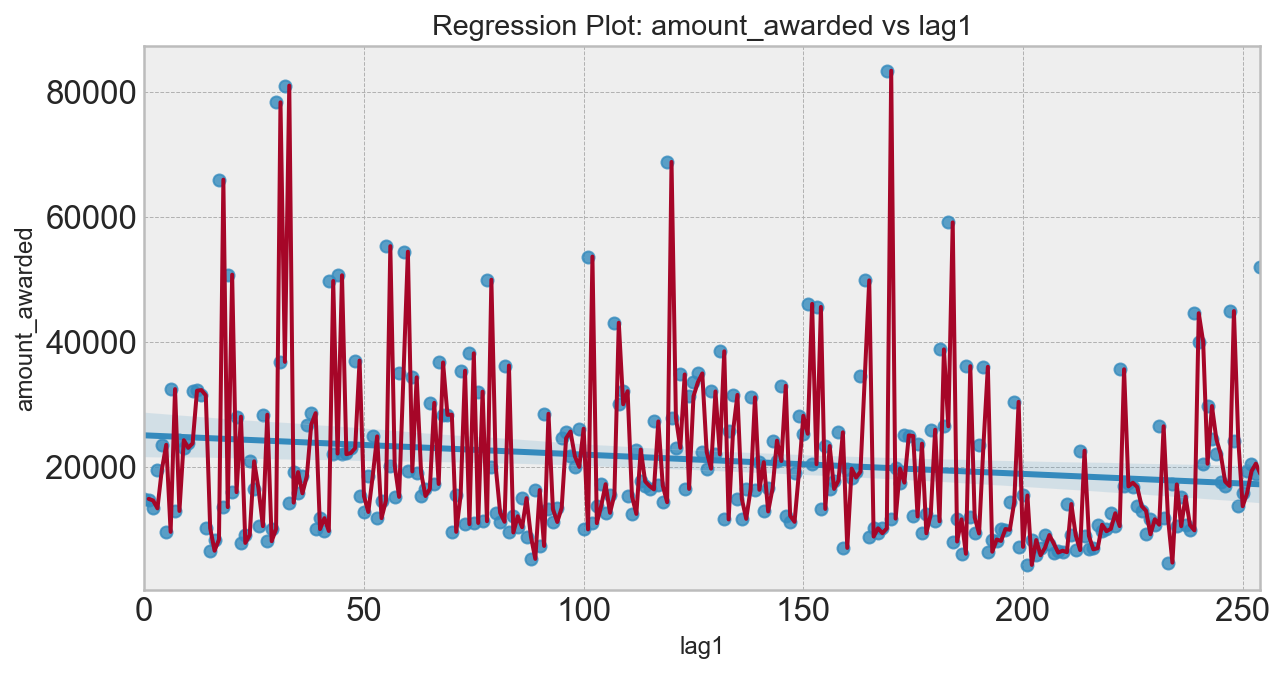

In [33]:
awards_by_week_5y['lag2'] = awards_by_week_5y['amount_awarded'].shift(1)
X = awards_by_week_5y.reset_index().index
y = awards_by_week_5y.amount_awarded

pred_values = awards_by_week_5y['lag2']
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x=X, y=y, data=awards_by_week_5y, ax=ax)
ax.plot(X, pred_values)
ax.set_title('Regression Plot: amount_awarded vs lag1')
ax.set_xlabel('lag1')
plt.show();

In [37]:
awards_by_week_5y['lag2'] = awards_by_week_5y['amount_awarded'].shift(3)
X = awards_by_week_5y[['amount_awarded','lag2']].copy()
X.dropna(inplace=True)

X.corr()

,amount_awarded,lag2
amount_awarded,1.000000,-0.032044
lag2,-0.032044,1.000000


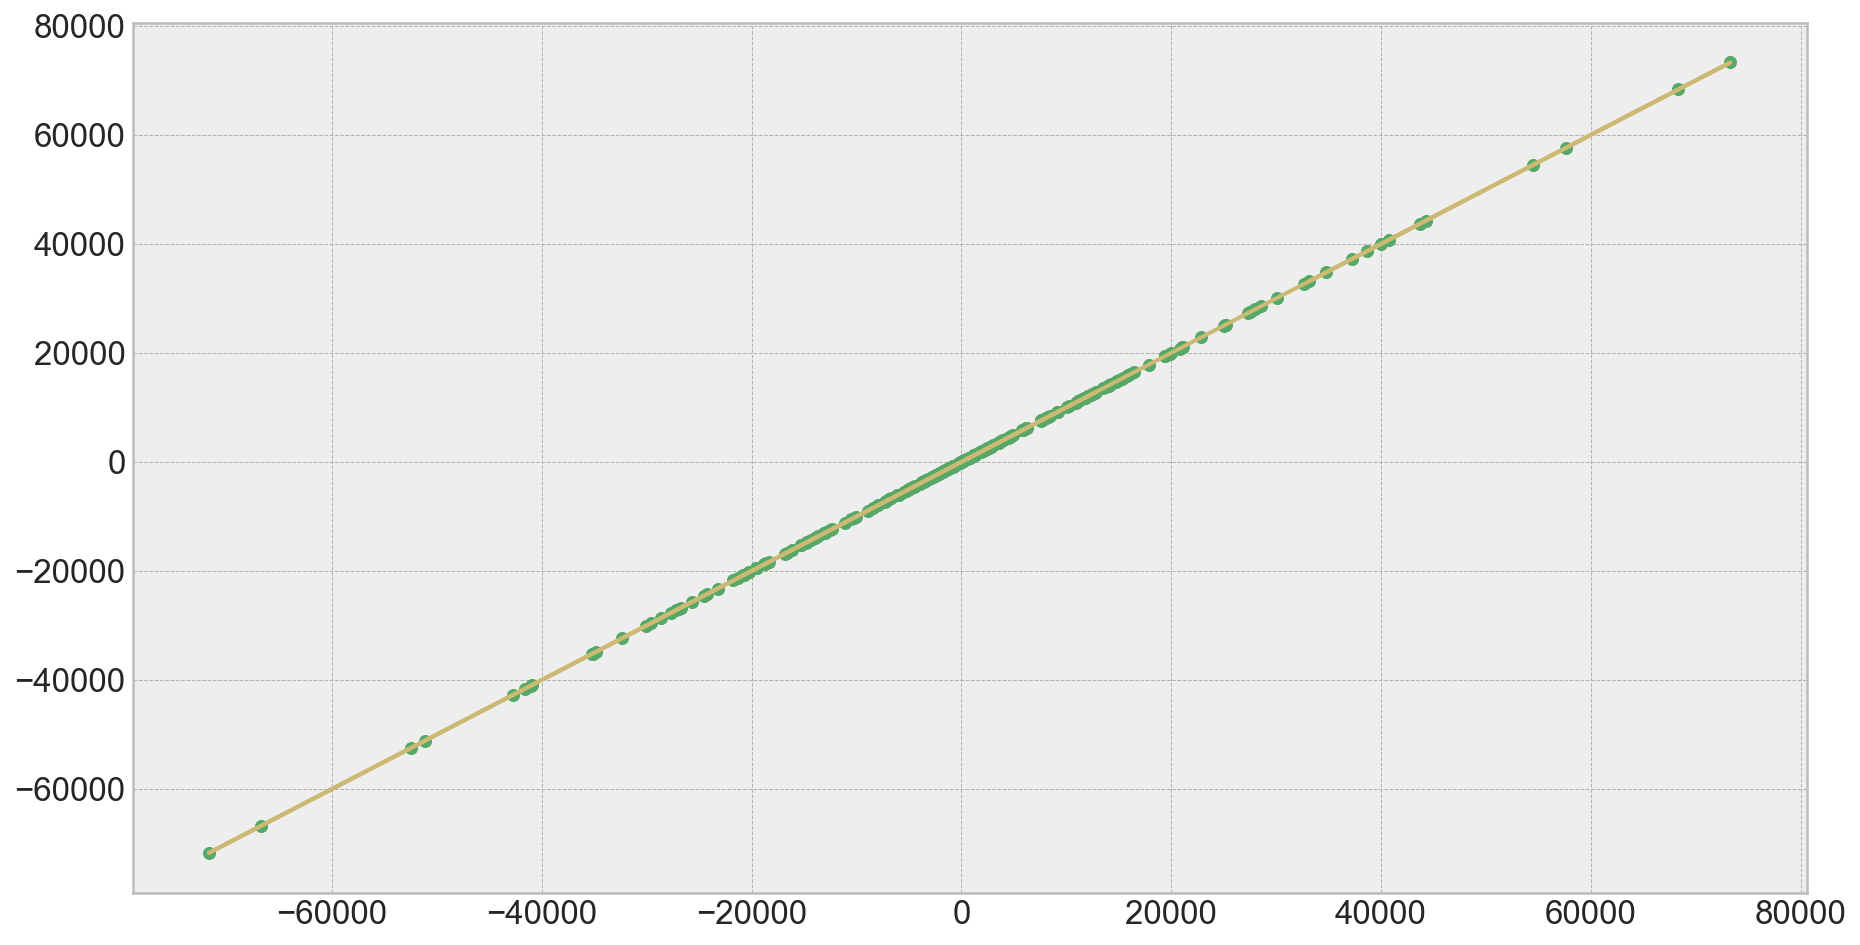

In [38]:
# plot residuals
df = awards_by_week_5y.copy()
fig, ax = plt.subplots(figsize=(15,8))
predictor = 'diff'
pred_values = df['diff'].values
df['y_bar'] = df['diff'].mean()
#baseline_residuals = [(i[0]-i[1]) for i in zip(df['diff'], df['y_bar'])]
#new_residuals = [(i[0]-i[1]) for i in zip(df['diff'], pred_values)]
ax.scatter(df[predictor], df['diff'], color='g')
ax.plot(df[predictor], pred_values, color='y')
ax.vlines([x for x in df[predictor]], [p for p in pred_values], [y for y in df['diff']])
plt.show();

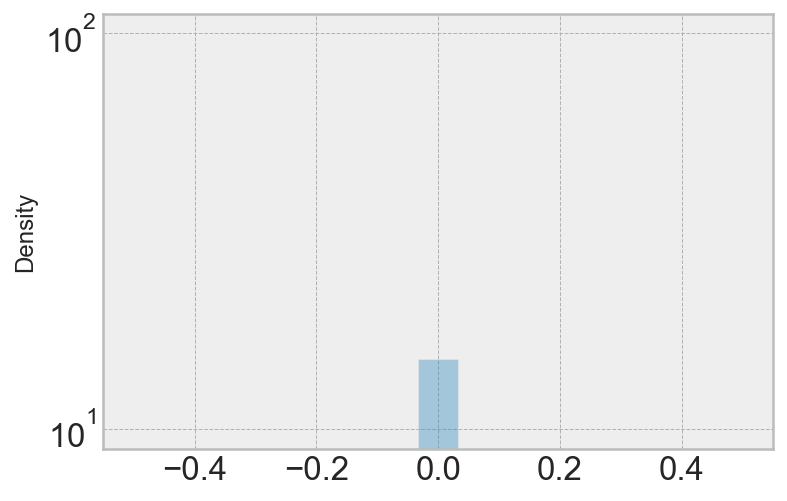

In [39]:
residuals = [i[0]-i[1] for i in zip(pred_values, df['diff'])]
sns.distplot(residuals)
plt.yscale('log')
plt.show;

In [40]:
df['residuals'] = residuals
df['pred_values'] = pred_values

In [41]:
df.residuals.map(lambda x: x**2).mean()
df.residuals.map(lambda x: x**2).mean()**0.5

0.0

0.0

In [42]:
np.allclose(sum(residuals[4:]), 0)
sum(residuals[4:])

True

0.0

There is less correlation between date and award in the last 5 years.

### 1.3.2 ACF and PACF

In [43]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tqdm import tqdm
from scipy import stats

In [44]:
def autocorr_plots(y, lags=20, alpha=0.05, figsize=(12,4)):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=figsize, sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'Autocorrelation at {lags} lag/s')

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'Partial Autocorrelation at {lags} lag/s')

    return fig, ax

In [45]:
def pandas_autocorr(y, lag=1):
    X = pd.DataFrame({'a': y, 'b': y.shift(lag)}).copy()
    X.dropna(inplace=True)
    autocorr = X.corr().iloc[0, 1]
    return X

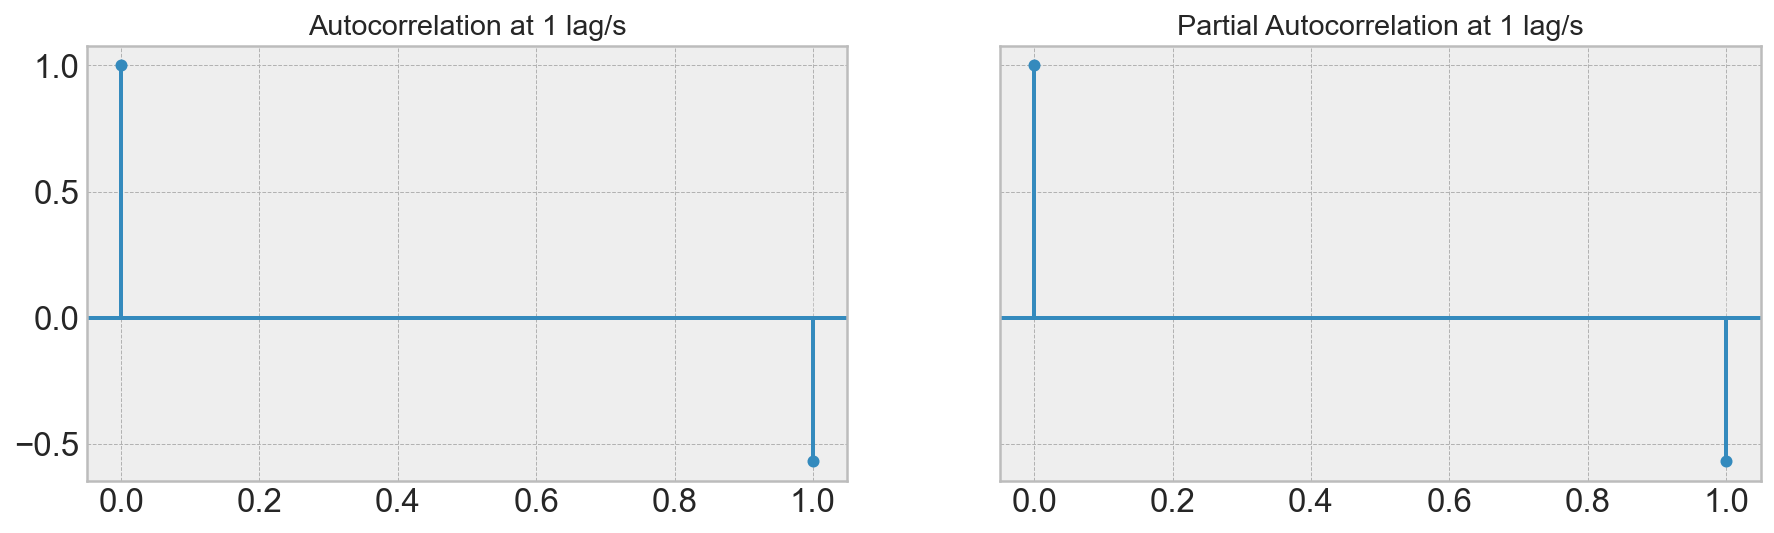

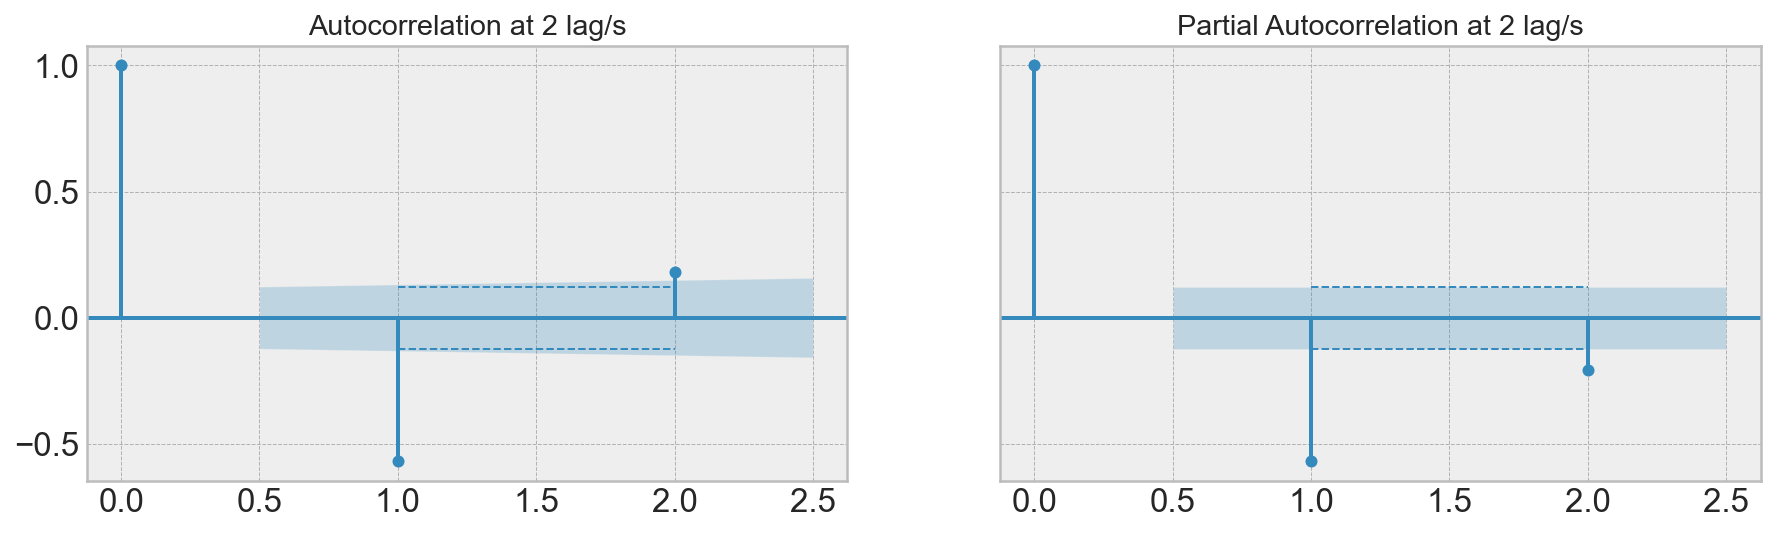

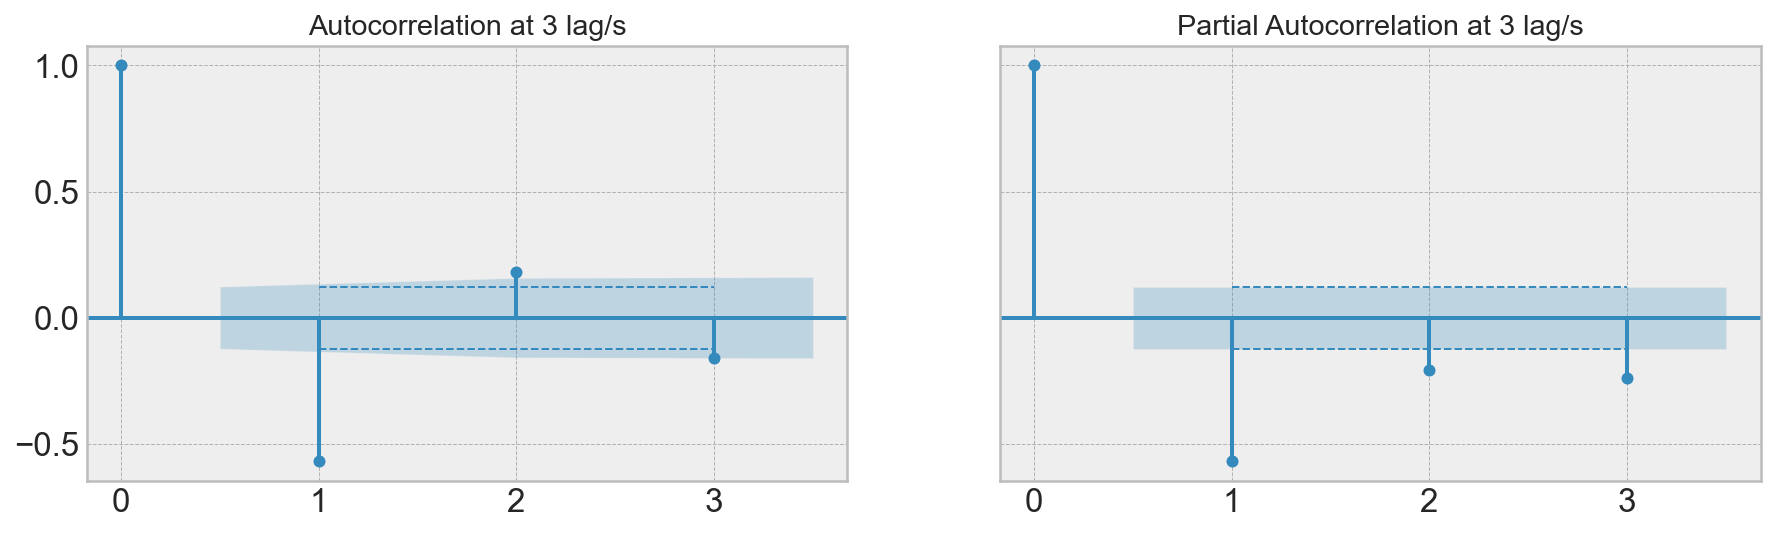

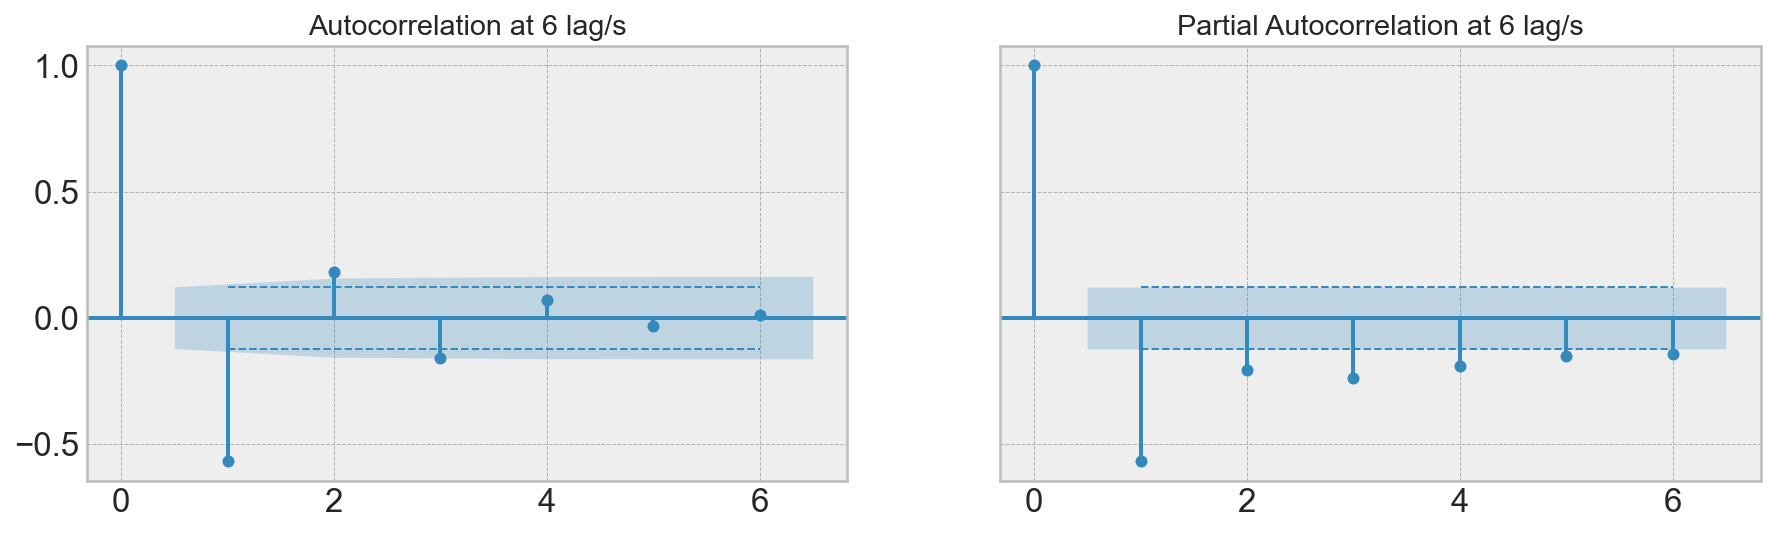

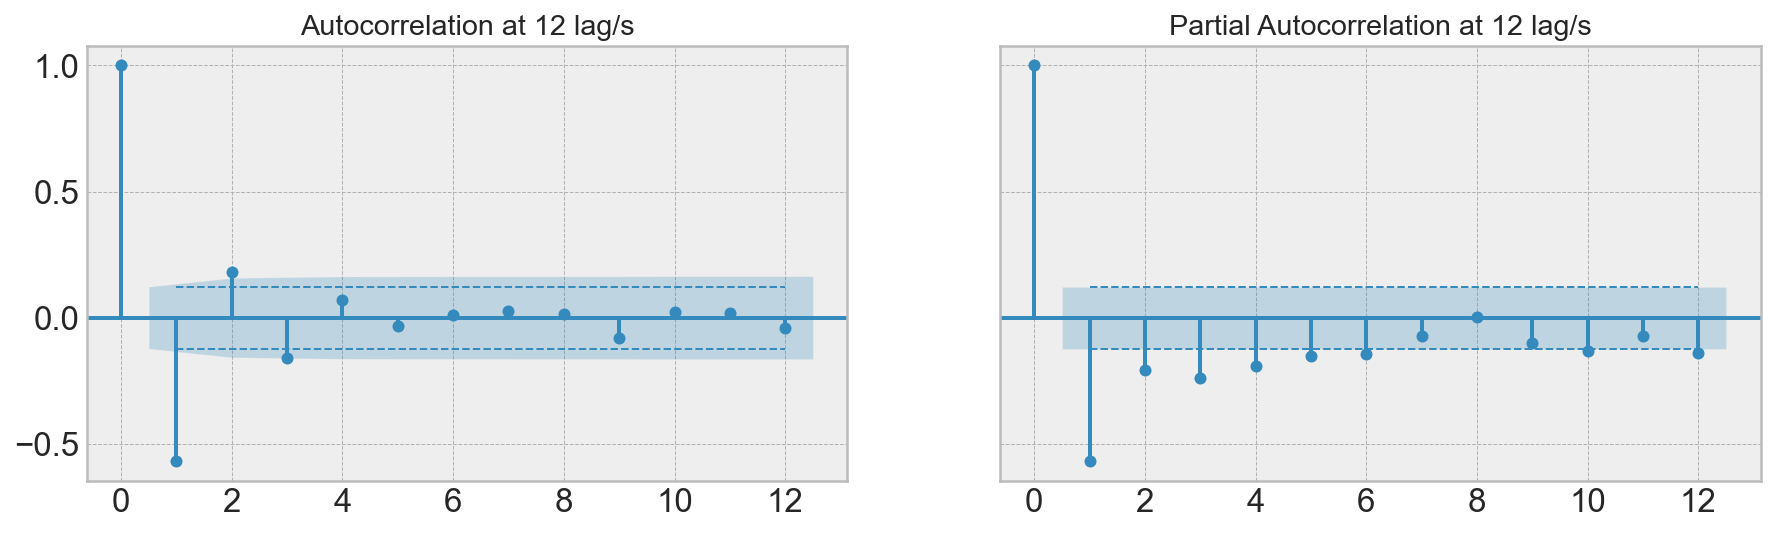

In [46]:
for i in [1, 2, 3, 6, 12]:
    fig, ax = autocorr_plots(awards_by_week_5y['diff'], lags=i, alpha=0.05, figsize=(15,4))

### 1.4 ARIMA Models

Judging by the ACF lag 1 is negatively autocorrelated by -0.5 and the PACF indicates that lags 2, 3 and 4 have some effect on the grant awarded at time 0.

We should start with a MA(1) model since PACF does tails off to 0 and PACF does not.  These are the P/ACFs for first order differenced data, so the likely model is ARIMA(0,1,1).


In [47]:
data = awards_by_week_5y['amount_awarded']
model = sm.tsa.statespace.SARIMAX(data, order=(0, 1, 1))
results = model.fit(maxiter=5000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         amount_awarded   No. Observations:                  255
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2779.449
Date:                Wed, 26 May 2021   AIC                           5562.898
Time:                        15:48:24   BIC                           5569.972
Sample:                    06-05-2016   HQIC                          5565.744
                         - 04-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9329      0.030    -31.034      0.000      -0.992      -0.874
sigma2      1.861e+08   1.53e-11   1.22e+19      0.000    1.86e+08    1.86e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               297.30
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+34. Standard errors may be unstable.
"""

In [48]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [49]:
from itertools import combinations, permutations
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [50]:
perms = permutations(range(0,3), 2)
orders = []
for p in perms:
    for d in [1,2]:
        for t in ['n', 'c', None]:
            orders.append(p[:1]+(d,)+p[1:]+(t,))

In [51]:
ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(data)]
test_size = splits[0][1].shape[0]

In [60]:
cv_scores = {}
pbar = tqdm(orders)
for order in pbar:
    pbar.set_description(f"Processing {order}")
    mses = []
    for i in range(ts.n_splits):
        try:
            y_train = data.iloc[splits[i][0]]
            y_test = data.iloc[splits[i][1]]
            model_cv = sm.tsa.statespace.SARIMAX(y_train, order=order[:3], trend=order[3:][0])
            results_cv = model_cv.fit(maxiter=5000)
            pred_test = results_cv.predict(start=0, end=len(y_train)+test_size-1, dynamic=False)[-test_size:]
            mses.append(mean_squared_error(y_test, pred_test))
        except Exception as e:
            print(e)
            mses.append(np.NaN)
            continue
    cv_scores[order] = mses
    clear_output(wait=True)

Processing (2, 2, 1, None): 100%|██████████| 36/36 [00:08<00:00,  4.42it/s]


In [61]:
df_scores = pd.DataFrame(cv_scores).T.mean(axis=1).reset_index().sort_values(0)
df_scores.columns = ['p', 'd', 'q', 't', 'cv_score']
df_scores['cv_score_sqrt'] = df_scores['cv_score']**0.5
df_scores.head(5)

,p,d,q,t,cv_score,cv_score_sqrt
0,0,1,1,n,1.666965e+08,12911.100528
2,0,1,1,NaN,1.666965e+08,12911.100528
32,2,1,1,NaN,1.669487e+08,12920.861305
30,2,1,1,n,1.669487e+08,12920.861305
6,0,1,2,n,1.678340e+08,12955.075059


The best scoring is 1st-order differentiated, 2nd-order autoregressive and 1st-order moving average.

In [62]:
data = awards_by_week_5y['amount_awarded']
model = sm.tsa.statespace.SARIMAX(data, order=(0, 1, 1))
results = model.fit(maxiter=5000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         amount_awarded   No. Observations:                  255
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2779.449
Date:                Wed, 26 May 2021   AIC                           5562.898
Time:                        15:51:03   BIC                           5569.972
Sample:                    06-05-2016   HQIC                          5565.744
                         - 04-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9329      0.030    -31.034      0.000      -0.992      -0.874
sigma2      1.861e+08   1.53e-11   1.22e+19      0.000    1.86e+08    1.86e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               297.30
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+34. Standard errors may be unstable.
"""

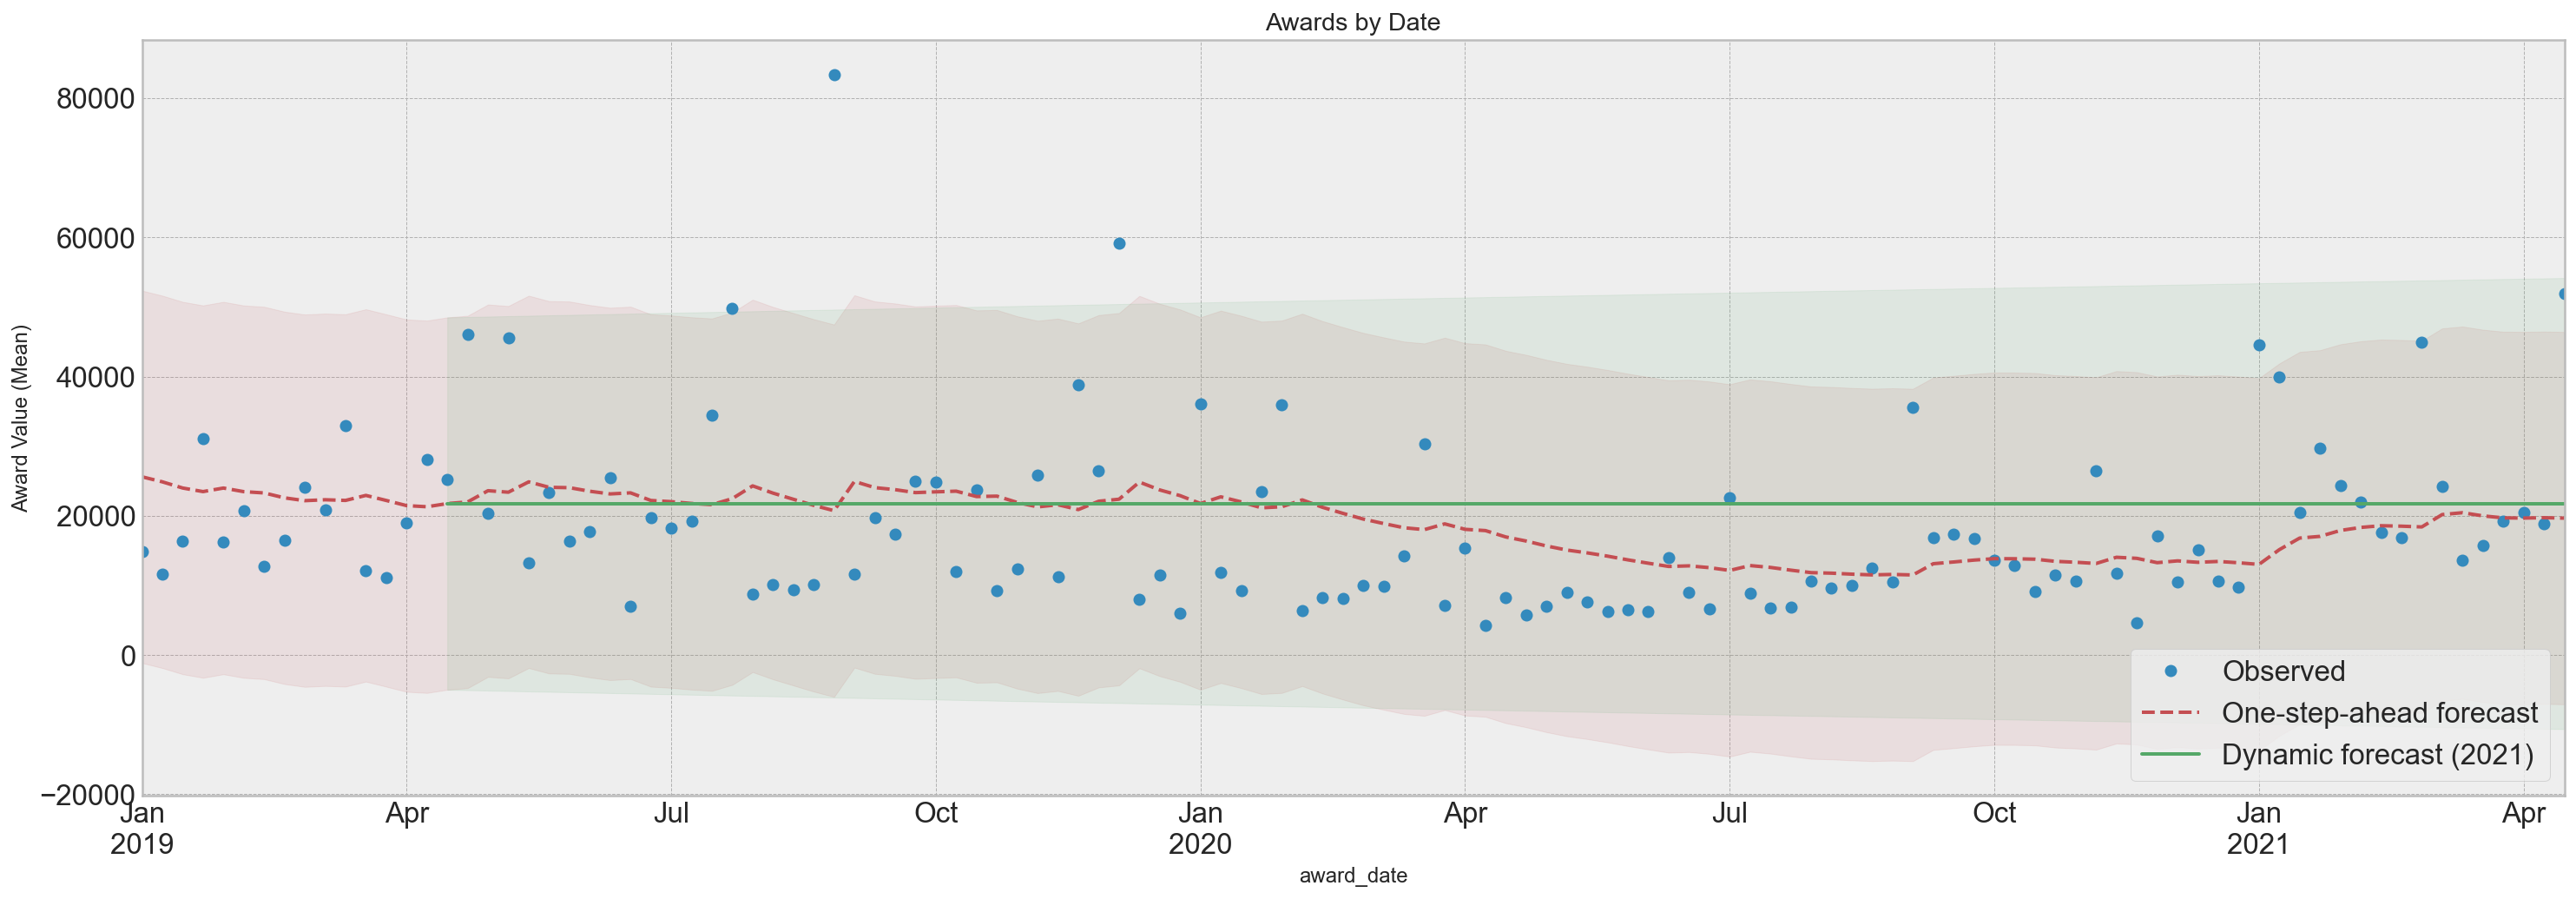

In [70]:
# predictions
predict = results.get_prediction()
predict_ci = predict.conf_int()

# dynamic predictions
start_date = '2019-01-01'
date_time_obj = datetime.datetime.strptime(start_date, '%Y-%m-%d')
#forecast_date = pd.to_datetime(date_time_obj+relativedelta(months=6))
#print(f"Start date points from {start_date}\nstart dynamic forecasting from {year_forecast_date}")
predict_dy = results.get_prediction(start=150, dynamic=True)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(25,8))
npre = 4
ax.set(title='Awards by Date', xlabel='Date', ylabel='Award Value (Mean)')

# Plot data points
data.loc[start_date:].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[start_date:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[start_date:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc[start_date:].plot(ax=ax, style='g', label='Dynamic forecast (2021)')
ci = predict_dy_ci.loc[start_date:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')
plt.show();

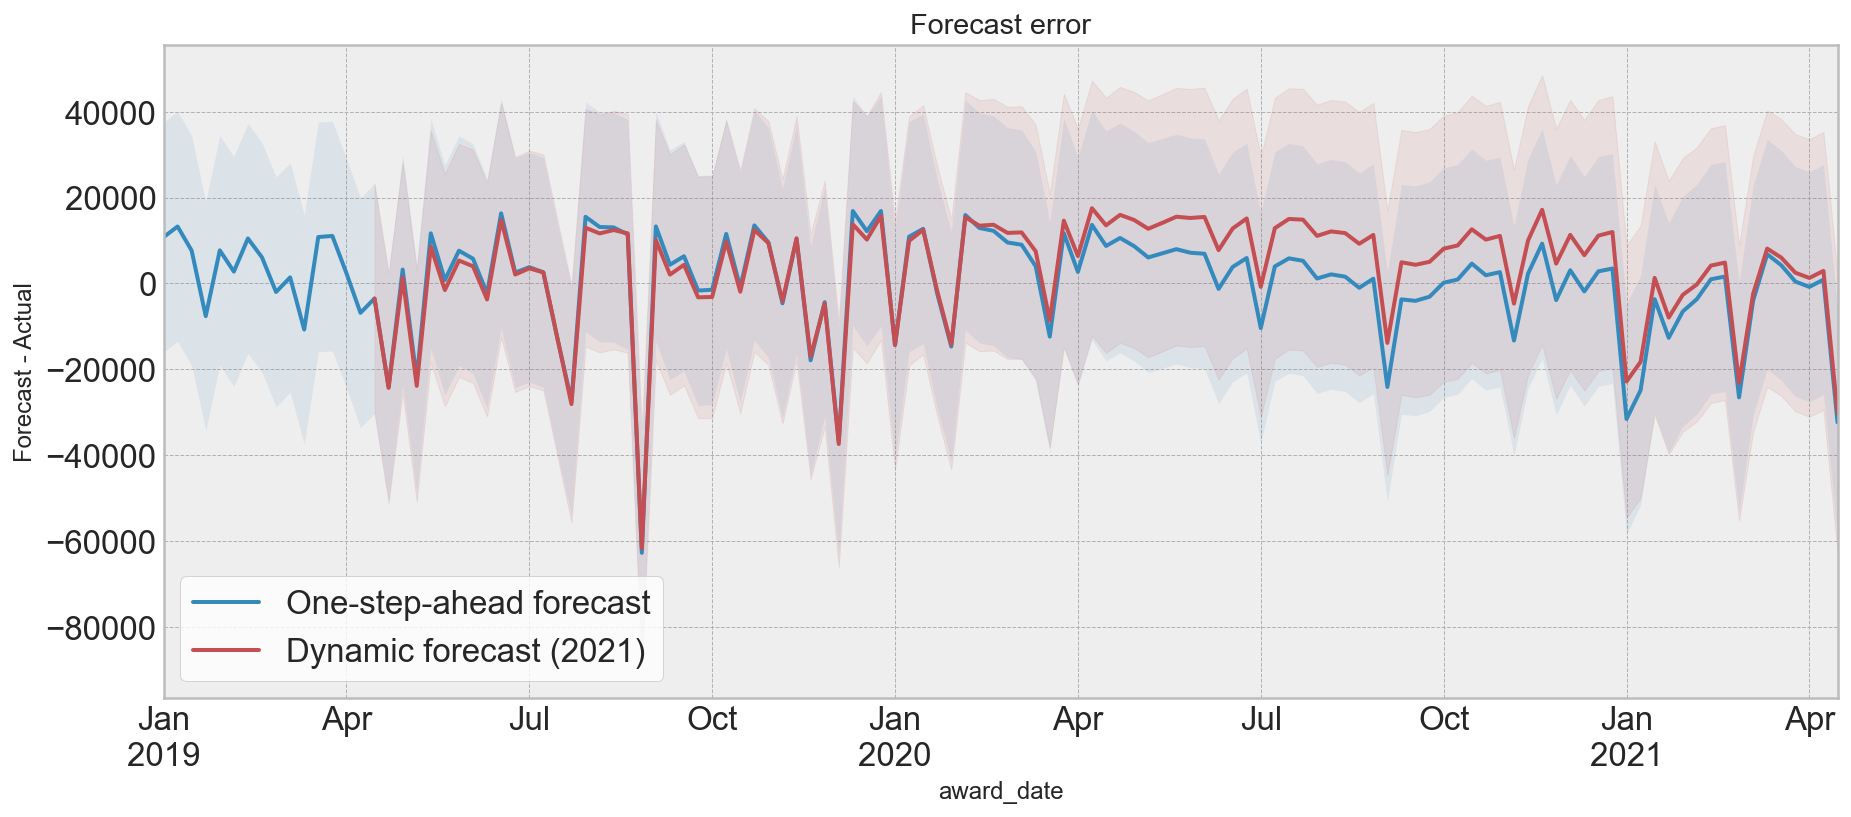

In [71]:
# Prediction error

X = data.index
y = data

# Graph
fig, ax = plt.subplots(figsize=(15,6))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - y
predict_error.loc[start_date:].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc[start_date:].copy()
ci.iloc[:,0] -= y.loc[start_date:]
ci.iloc[:,1] -= y.loc[start_date:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - y
predict_dy_error.loc[start_date:].plot(ax=ax, style='r', label='Dynamic forecast (2021)')
ci = predict_dy_ci.loc[start_date:].copy()
ci.iloc[:,0] -= y.loc[start_date:]
ci.iloc[:,1] -= y.loc[start_date:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')
plt.show();